In daily life, "probability" and "likelihood" are used interchangeably. But, they don't refer to the same thing. I believe the most intuitive way to distinguish both is by thinking about the information you have while answering questions:

- Probability questions start with *known model* and *unknown data*. If someone asks you about the chance of seeing 6 heads in 10 coin tosses, you don't have any observations. But, you have the model: You know the process that generates "heads" and "tails" and it's parameter value (usually expressed as theta *θ*): 0.5.
- Let's say you did 10 coin tosses and ended up with 9 heads. How likely you were to observe 9 if the coin was fair? In this situation, the data is *known* and the question refers to the underlying data generating process (i.e., refers to the parameter).

We can use this type of approach and let the parameter values *vary* and calculate the likelihood of the data under each value of the parameter(s).

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels as sm
import empiricaldist as emd
import scipy.stats as st

import utils as ut

import warnings

warnings.filterwarnings('ignore')

In [2]:
possum = pd.read_csv('possum.csv', usecols=['pop', 'tail_l'])
df = possum.copy()

df.head()

,pop,tail_l
0,Vic,36.0
1,Vic,36.5
2,Vic,39.0
3,Vic,38.0
4,Vic,36.0


We'll use possum data, where each row corresponds to features of a possum from Australia and New Guinea. Let's attempt to predict which region a possum is from as a function of tail length.

I assume basic knowledge of logistic regression, which we'll use to model the relationship between our predictor and the binary target variable.

In [3]:
qs_cept = np.linspace(-3, 3, 241) # possible values for intercept (beta_0)
qs_slope = np.linspace(-1, 1, 81) # possible values for slope (beta_1)

In [4]:
print(qs_cept[:5], '\n', qs_slope[:5])

[-3.    -2.975 -2.95  -2.925 -2.9  ] 
 [-1.    -0.975 -0.95  -0.925 -0.9  ]


In [5]:
df_likeli = pd.DataFrame(index=range(len(qs_cept)), columns=range(len(qs_slope)))
df_likeli.index = qs_cept
df_likeli.columns = qs_slope

In [6]:
df_likeli.fillna(1, inplace=True)

df_likeli.head()

,-1.000,-0.975,-0.950,-0.925,-0.900,-0.875,-0.850,-0.825,-0.800,-0.775,...,0.775,0.800,0.825,0.850,0.875,0.900,0.925,0.950,0.975,1.000
-3.000,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
-2.975,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
-2.950,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
-2.925,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
-2.900,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


So, what I have done is I created grid of equally spaced values both for intercept and the slope. I put them into a dataframe where columns represent possible values for slope and indices represent possible values for intercept.

Now, I ask this question: For each pair of intercept and slope, b0 and b1, how likely I am to see the observed data?

In [7]:
df['pop'] = df['pop'].apply(lambda x: 1 if x == 'Vic' else 0)

In [8]:
# Centering data

offset = df['tail_l'].mean().round()
df['x'] = df['tail_l'] - offset
df['y'] = df['pop']

# I refer our predictor as x from now on (for convenience), y becomes our target variable which takes 1 if possum is from Victoria region and 0 otherwise.

In [9]:
agg_data = df.groupby('x')['y'].agg(['sum', 'count'])
agg_data.head(10).T

x,-5.0,-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5,0.0,0.5
sum,2,1,4,2,6,6,9,4,4,1
count,2,1,5,2,9,7,13,12,6,4


In [10]:
ns = agg_data['count'] # represents number of observation with corresponding x values
ks = agg_data['sum'] # represents successes, which means Victoria region

People get confused, rightfully, when they hear logistic regression getting mentioned as a linear model since all they see is an S-shaped function in a classic graph where x-axis represents the predictor and y-axis represents the probability. But that squiggle is a result of a transformation of log odds into probabilities. You may have deduced that before if you have taken a look at the equation:

$\displaystyle log_e(\frac{p_i}{1 - p_i}) = \beta_0 + \beta_1 x_{1i} + ... + \beta_k x_{k_i}$

However, we know that odds can be expressed as probabilities, so we'll make that transformation.

For representation let's select an intercept and a slope:

In [11]:
cept = 0
slope = 1

In [12]:
x_values = agg_data.index
log_odds = cept + slope * x_values
odds = np.exp(log_odds)
ps = odds / (odds + 1)
ps[:6] # Probabilities coming from the model

Index([0.006692850924284856, 0.029312230751356316,  0.04742587317756679,
        0.07585818002124356,  0.11920292202211755,  0.18242552380635632],
      dtype='float64', name='x')

How likely I am to observe k success in n trials with $p_i$ where $p_i$ comes from the model above.

In [13]:
# How likely I am to observe k success in n trials with p_i where p_i comes from model
likelis = st.binom.pmf(ks, ns, ps)
likelis[:6]

array([4.47942535e-05, 2.93122308e-02, 2.40951774e-05, 5.75446348e-03,
       1.64675234e-04, 2.10930303e-04])

In [14]:
# Taking the product for whole data
likelis.prod()

6.58621661515704e-55

Let's take a look at the fit:

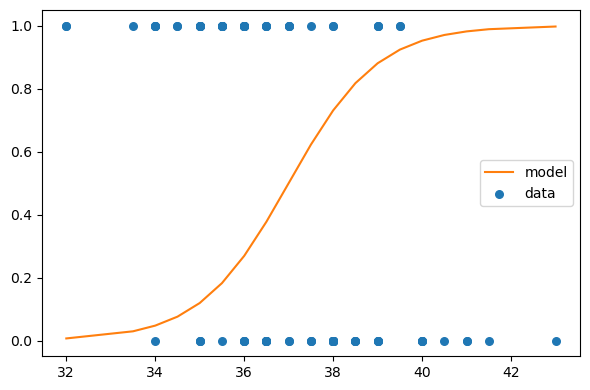

In [15]:
plt.figure(figsize=(6,4))

plt.plot(x_values+offset, ps, label='model', color='C1')
plt.scatter(df['x']+offset, df['y'], s=30, label='data')

ut.decorate()

This was for only one pair of intercept and slope, and it seems like we can do better. We calculated the likelihood for education purposes here but in general, likelihoods by themselves does not mean much (it's relatively a ). Let's try other possible pairs for our parameters and compare the likelihoods of each to take the one that maximizes the likelihood of the observed data.

In [16]:
from scipy.special import expit

likelihood = df_likeli.copy()

for cept in likelihood.index:
    for slope in likelihood.columns:
        probs = expit(cept + slope * x_values) # transformation to probabilities
        likelis = st.binom.pmf(ks, ns, probs) # likelihood of each observation
        likelihood.loc[likelihood.index == cept, slope] = likelis.prod() # likelihood of the whole data under the selected pair of parameter values

In [17]:
row, col = likelihood.stack().idxmax()
print(row, col)

-0.32499999999999973 -0.7


This is the pair that maximizes the likelihood.

In [18]:
cept = row
slope = col

log_odds = cept + slope * x_values
odds = np.exp(log_odds)
ps = odds / (odds + 1)

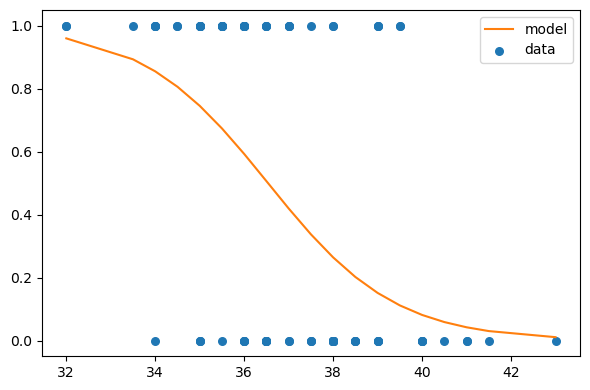

In [19]:
plt.figure(figsize=(6,4))

plt.plot(x_values+offset, ps, label='model', color='C1')
plt.scatter(df['x']+offset, df['y'], s=30, label='data')

ut.decorate()

Let's check our parameter estimates with the help of statsmodels:

In [20]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.logit(formula, data=df).fit(disp=False)
results.params

Intercept   -0.320498
x           -0.699641
dtype: float64

We didn't get those exact values since we used *grid approximation*, and the grid that I created didn't include those exact values. Let's drop a few details here:

- As the parameter space gets larger, the computational process becomes slower. So, there's that trade-off between precision and time.
- We only had two parameters to estimate and that's OK for grid approach. However, once you start to get more than three, number of possible combination for parameters gets incredibly large which makes grid approach infeasible.
- Another thing is related to the number of observation while calculating the likelihood: When you try to take the product of the likelihoods when there are many observations, you may ran into a issue called *underflow*, where computer has trouble multiplying bunch of values around zero. Hence, *log likelihood* comes to rescue: Logarithms takes the values around zero away from zero, thus solving the underflow problem.

I hope this example made likelihoods more intuitive. There's more to know about them: Are they probability densities? Are they probability masses? Or are they both? That's for a whole different post, things can get messy in a second. However, it's important to understand likelihoods in the context above, since they can be used to update our beliefs about parameters which is what we do with Bayesian methods.

As usual, have a nice weekend :)